## dap-spring-2022

### project topic
# **Analysis of Pokemon statistics and gameplay in Pokemon Go**

**Group:** 20Э3 <br>

**Authors:**
- Андреева Арина Андреевна aaandreeva_14@edu.hse.ru <br>
- Южаков Дмитрий Алексеевич dayuzhakov@edu.hse.ru

    
**Description:** Pokémon - это медиа-франшиза, которая начиналась как пара видеоигр для ролевых игр. Покемоны - это вымышленные звероподобные монстры, которые живут в (конечно, тоже придуманном) мире покемонов.
> Почти все Игры с покемонами включают в себя эти бои, но в разных манерах. В некоторых из них пользователь должен полагаться на свою
стратегию и силу своего покемона, в то время как другие видеоигры в большей степени основаны на способностях.

Следовательно, интересным фактом этой игры вполне может быть то, как сила или способность сражаться покемона
описанный. Это зависит, опять же, от типа видеоигры. Для целей статистического анализа наиболее
привлекательным способом описания покемонов является описание характеристик. Каждый покемон описывается большим количеством переменных.
> У
нас есть не только боевая статистика (переменные, описывающие способность сражаться), но и множество переменных, описывающих
более подробная информация о каждом покемоне, например, Кастомизация или вероятность того, что он женского или мужского пола.

Таким образом, мы можем статически анализировать большое разнообразие переменных, используемых для описания покемонов, и есть шанс
найти взаимосвязи между ними, а также сгруппировать покемонов по некоторым критериям..
<br>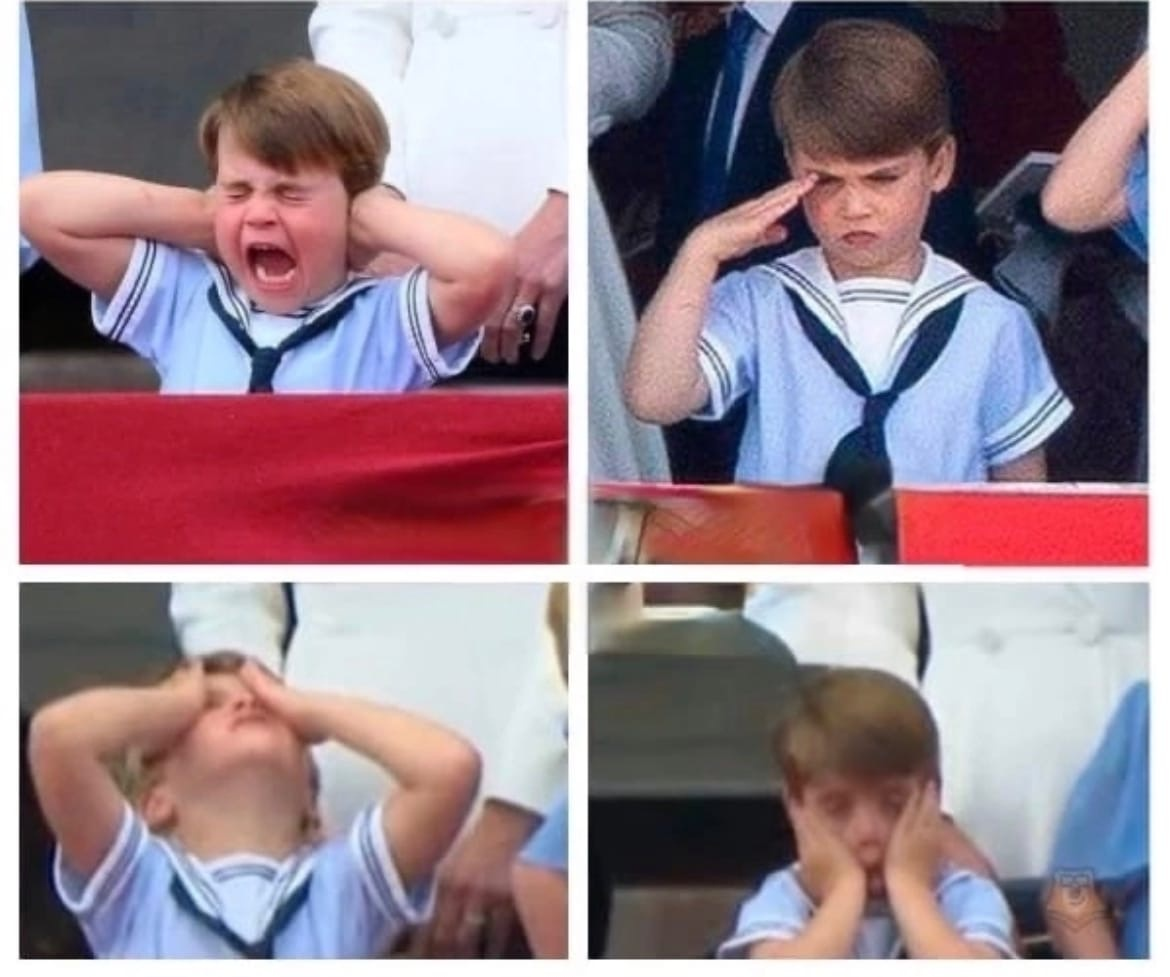

____

In [ ]:

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
!pip install squarify
import squarify
import seaborn as sns
import plotly.graph_objects as go
import scipy.cluster.hierarchy as shc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Работа с данными и их корректировка**
### Парсинг таблицы с сайта

In [ ]:
REQUEST_URL = 'https://pokemondb.net/pokedex/all'
api_resp = requests.get(REQUEST_URL)
api_resp #проверяем статус запроса, т.к 200 всё хорошо, сервер позволил собирать информацию

<Response [200]>

In [ ]:
resp_text = api_resp.text
resp_soup = BeautifulSoup(resp_text, 'lxml')
print(resp_soup.prettify()) #выгружаем весь текст страницы

In [ ]:
tree = BeautifulSoup(resp_text, 'html.parser')

In [ ]:
table1 = resp_soup.find('table', id='pokedex')  #в коде страницы нашли таблицу и её id
headers = []
for i in table1.find_all('th'): #согласно коду элементов заголовки колонок имеют тег th, по котрому мы их находим в коде
    title = i.text
    headers.append(title)
headers  #получили список заголовков колонок

['#',
 'Name',
 'Type',
 'Total',
 'HP',
 'Attack',
 'Defense',
 'Sp. Atk',
 'Sp. Def',
 'Speed']

In [ ]:
headers[0] = 'ID' #изменим название одного из столбцов для наглядности
df = pd.DataFrame(columns = headers) #создадим таблицу с заголовками
df

,ID,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed


In [ ]:
for j in table1.find_all('tr')[1:]: #согласно коду страницыстроки имеют тег tr, по котрому мы их находим в коде
    row_data = j.find_all('td') #согласно коду страницы элементы имеют тег td, по котрому мы их находим в коде
    row = [i.text for i in row_data]
    length = len(df)
    df.loc[length] = row #перебираем каждую из строк и элементов в ней и заполняем таблицу данными

In [ ]:
df.head()

,ID,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,001,Bulbasaur,Grass Poison,318,45,49,49,65,65,45
1,002,Ivysaur,Grass Poison,405,60,62,63,80,80,60
2,003,Venusaur,Grass Poison,525,80,82,83,100,100,80
3,003,Venusaur Mega Venusaur,Grass Poison,625,80,100,123,122,120,80
4,004,Charmander,Fire,309,39,52,43,60,50,65


## Преобразование данных:
- переименование столбцов в датасете,
- преобразование типов данных,
- добавление новых столбов и тп.

In [ ]:
df[['ID','Total','HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']] = df[['ID','Total','HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].astype(int)
#изменит тип данных в столбцах со строк на числовые, для того,чтобы дальше работать с ними

In [ ]:
conditions = [
    (df['ID'] < 152),
    (df['ID'] > 151) & (df['ID'] <= 251),
    (df['ID'] > 251) & (df['ID'] <= 386),
    (df['ID'] > 386) & (df['ID'] <= 493),
    (df['ID'] > 493) & (df['ID'] <= 649),
    (df['ID'] > 649) & (df['ID'] <= 721),
    (df['ID'] > 721) & (df['ID'] <= 809),
    (df['ID'] > 809) & (df['ID'] <= 905),
    ]

# сощдаем листы с условиями и значениями, соответсвующие условиям
values = ['1', '2', '3', '4', '5', '6', '7', '8']

# добавляем новый столбец, в котором указывается поколение покемона в зависимости от его ID
df['Generation'] = np.select(conditions, values)
df.head()

,ID,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
0,1,Bulbasaur,Grass Poison,318,45,49,49,65,65,45,1
1,2,Ivysaur,Grass Poison,405,60,62,63,80,80,60,1
2,3,Venusaur,Grass Poison,525,80,82,83,100,100,80,1
3,3,Venusaur Mega Venusaur,Grass Poison,625,80,100,123,122,120,80,1
4,4,Charmander,Fire,309,39,52,43,60,50,65,1


In [ ]:
df[['main_type','secondary_type']] = df.Type.apply(
   lambda x: pd.Series(str(x).split(" ")))
df = df.drop('Type', axis = 1)
#делим один столбец на несколько, так как в нем указаны два типа, а нам хотелось бы их распределить на главный и второстепенный

## **Загружаем данные второй таблицы, объдиняем и обрабатываем данные**
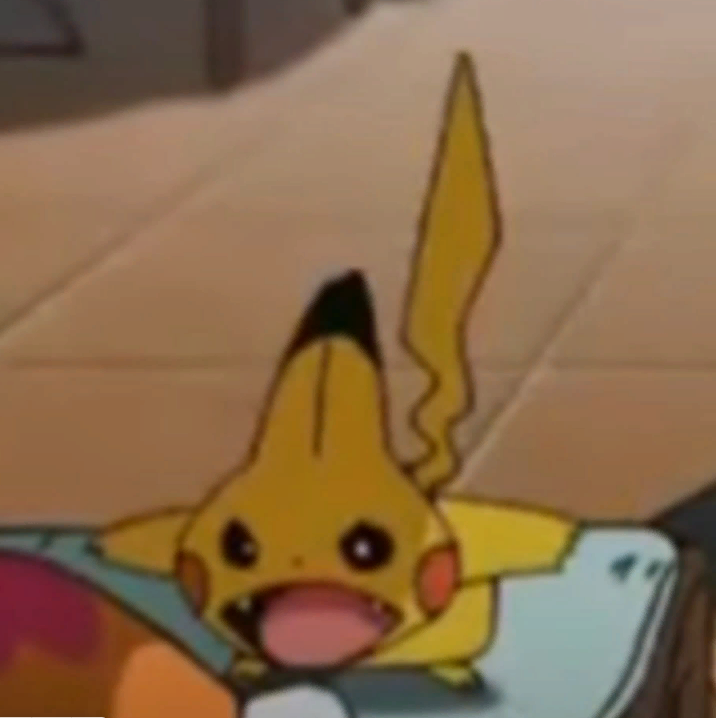

In [ ]:
df2 = pd.read_csv('https://raw.githubusercontent.com/arinaaandreeva/Pokemons/main/pokemon.csv') # загружаем вторую таблицу из csv-файла

In [ ]:
df.columns = [x.lower() for x in df.columns]
df2.columns = [x.lower() for x in df2.columns]  # перевели названия всех столбцов в нижний регистр, чтобы потом удалить дубликаты
df = df.merge(df2, left_on = 'name', right_on = 'pokemon_name', how = 'inner', suffixes=('', '_y')) #объединяем две таблицы
def drop_y(df):
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)
drop_y(df)
#с помощью drop_y удалили дубликаты столбцов
df

In [ ]:
df.dtypes #проверяем все ли данные того типа, которого нужно

id                 int64
name              object
total              int64
hp                 int64
attack             int64
defense            int64
sp. atk            int64
sp. def            int64
speed              int64
generation        object
main_type         object
secondary_type    object
number             int64
pokemon_name      object
pic_url           object
region            object
category          object
height            object
weight            object
pokemon_family    object
stamina            int64
cp_range          object
hp_range          object
capture_rate      object
flee_rate         object
male_perc         object
female_perc       object
resistance        object
weakness          object
wild_avail        object
egg_avail         object
raid_avail        object
research_avail    object
shiny             object
shadow            object
pkedex_desc       object
poss_attacks      object
dtype: object

In [ ]:
df.isna().sum(axis=0) #полученные значения суммы выражают число NA значений в столбце

id                  0
name                0
total               0
hp                  0
attack              0
defense             0
sp. atk             0
sp. def             0
speed               0
generation          0
main_type           0
secondary_type      0
number              0
pokemon_name        0
pic_url             0
region              0
category            0
height              0
weight              0
pokemon_family      0
stamina             0
cp_range            0
hp_range            0
capture_rate       65
flee_rate          65
male_perc         143
female_perc       143
resistance          8
weakness            8
wild_avail          0
egg_avail           0
raid_avail          0
research_avail      0
shiny               0
shadow              0
pkedex_desc         0
poss_attacks        0
dtype: int64

In [ ]:
df['male_perc'].unique() #получаем уникальные начения столбца для его последущей обработки

array(['87.5%', '50%', nan, '25%', '75%', '12.5%'], dtype=object)

In [ ]:
gender = []
for i in df['male_perc']:          # на основе процентного соотношения полов, задаем условия при которых Покемон считается мальчиком, девочкой, без пола или обоих гендеров
  if  i == '87.5%' or i == '75%':
    i = 'male'
    gender.append(i)
  elif i == '25%' or i == '12.5%':
    i = 'female'
    gender.append(i)
  elif i == '50%':
    i = 'both'
    gender.append(i)
  else:
    i = 'genderless'
    gender.append(i)

df['gender'] = gender  # создаем новый столбец
df[['male_perc', 'female_perc']].drop  #удаляем столбцы, которые больше не нужны


<bound method DataFrame.drop of     male_perc female_perc
0       87.5%       12.5%
1       87.5%       12.5%
2       87.5%       12.5%
3       87.5%       12.5%
4       87.5%       12.5%
..        ...         ...
742       50%         50%
743       50%         50%
744       50%         50%
745       NaN         NaN
746       NaN         NaN

[747 rows x 2 columns]>

In [ ]:
# производим замену пустых элементов в таблице на более подходящие значения (не удаляем пустые элементы, чтобы не удалить много покемонов и не исказить результаты анализа)
df['capture_rate'] = df['capture_rate'].fillna(0, inplace=False)
df['flee_rate'] = df['flee_rate'].fillna(0, inplace=False)
df['resistance'] = df['resistance'].fillna('do not resist', inplace=False)
df['weakness'] = df['weakness'].fillna('no weaknesses', inplace=False)

In [ ]:
# удаляем нерелевантные, повторяющиеся признаки
df = df.drop(['pokemon_name'], axis = 1)
df = df.drop(['number'], axis = 1)
df = df.drop(['pic_url'], axis = 1)


In [ ]:
#чистим вес и рост от показателей и делаем числовыми
df[['height_clear','name_met_h']] = df.height.apply(
   lambda x: pd.Series(str(x).split(" ")))

df[['weight_clear','name_kg_w']] = df.weight.apply(
   lambda x: pd.Series(str(x).split(" ")))

# удаляем ненужные столбцы
df = df.drop('height', axis = 1)
df = df.drop('name_met_h', axis = 1)
df = df.drop('weight', axis = 1)
df = df.drop('name_kg_w', axis = 1)

# меняем тип данных в столбцах
df[['height_clear', 'weight_clear']] = df[['height_clear', 'weight_clear']].astype(float)

In [ ]:
#делим столебц диапазонов на два крайних значения с помощью разделителя дефиса
df[['cp_range_min','cp_range_max']] = df.cp_range.apply(
   lambda x: pd.Series(str(x).split("-")))
df[['hp_range_min','hp_range_max']] = df.hp_range.apply(
   lambda x: pd.Series(str(x).split("-")))

 # заменяем точки на запятые, чтобы можно было изменить тип данных
df['cp_range_min'] = [x.replace(',', '.') for x in df['cp_range_min']]
df['cp_range_max'] = [x.replace(',', '.') for x in df['cp_range_max']]
df['hp_range_min'] = [x.replace(',', '.') for x in df['hp_range_min']]
df['hp_range_max'] = [x.replace(',', '.') for x in df['hp_range_max']]

# меняем тип данных на числовой
df[['cp_range_min', 'cp_range_max', 'hp_range_min', 'hp_range_max']] = df[['cp_range_min', 'cp_range_max', 'hp_range_min', 'hp_range_max']].astype(float)

In [ ]:
df = df.assign(cp_average = (df['cp_range_min'] + df['cp_range_max'])/2)# находим среднее значение боевой мощи покемона

In [ ]:
df = df.assign(hp_average = (df['hp_range_min'] + df['hp_range_max'])/2)#находим среднее значение попадания в покемона

In [ ]:
# Задаем условия для создания нового столбца, который более кратко описывает данные
wild_available = []
for i in df['wild_avail']:
  if i.startswith('Yes') or i == 'TBD':
    wild_available.append('Yes')
  elif i.startswith('No'):
    wild_available.append('No')

# Создание нового столбца
df['wild_availble'] = wild_available


In [ ]:
# Аналогичное создание новго столбца и задание условий для него
egg_available = []
for i in df['egg_avail']:
  if i.startswith('Yes') or i == '0':
    egg_available.append('Yes')
  elif i.startswith('No'):
    egg_available.append('No')

df['egg_available'] = egg_available

In [ ]:
# Аналогичное создание новго столбца и задание условий для него
raid_availble = []
for i in df['raid_avail']:
  if i.startswith('Yes'):
    raid_availble.append('Yes')
  elif i.startswith('No'):
    raid_availble.append('No')
  else:
    raid_availble.append('Formerly')

df['raid_availble'] = raid_availble

In [ ]:
 df['shiny'].unique()

array(['Yes', 'Yes (available forms listed below)', 'No'], dtype=object)

In [ ]:
shiny = []
for i in df['shiny']:
  if i.startswith('Yes'):
    shiny.append('Yes')
  else:
    shiny.append('No')

df['shiny'] = shiny

# **Анализ данных**

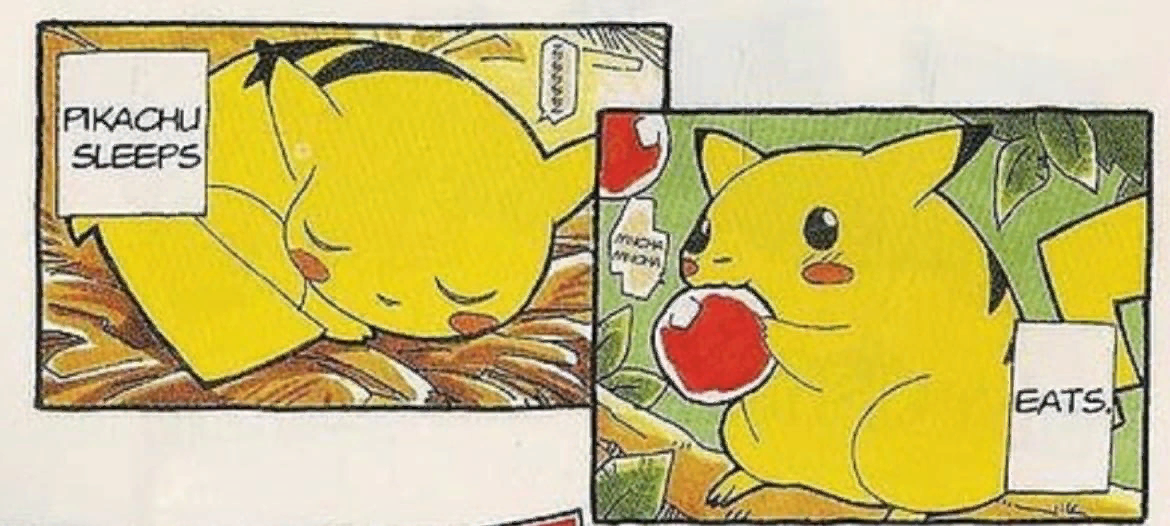

### **Описательные характеристики используемые в анализе**

*   name - Имя Покемона
*   total - Общая целочисленная характеристика Покемона
*   hp - Жизненные силы Покемона
*   attack - Показатели атаки Покемона
*   defense - Показатели защиты Покемона  
*   sp. atk -  Показатели специальной атаки Покемона
*   sp. def - Показатели специальной защиты Покемона
*   speed - Показатели скорости Покемона
*   generation - Принадлежность Покемона к поколению
*   main_type - Основной тип Покемона
*   secondary_type - Вторичный тип Покемона (или NULL только 1 тип)
*   region - Регион в Японии, где Покемоны впервые появились в категории игр с покемонами

* category - Категория покемонов, как любая отличительная черта вида Покемона
* height_clear  - Высота покемона
* weight_clear - Вес покемона
* pokemon_family - Производное семейство Покемонов (напр. Чармандер, Чармелеон, Чаризард - все они будут семьей Чармандер)
* stamina - Показатель выносливости Покемона
* cp_range - Диапазон боевой мощи покемонов (CP) в Pokémon Go, диапазон так же представлен ы сталбцах минимального и максимального значения, среднего значения в игре
* hp_range - Диапазон попадания покемонов (CP) в Pokémon Goo, диапазон так же представлен ы сталбцах минимального и максимального значения, среднего значения в игре
* capture_rate - Возможность захвата покемонов в Pokémon Go
* flee_rate - Возможность бегства покемонов в Pokémon Go

* resistant - Словарь сопротивлений покемонов определенным типам в следующей форме: {'percent_resistant': ['type_1', 'type_2']}
* weakness - Словарь слабостей покемонов для определенных типов в следующей форме: {'percent_weak': ['type_1', 'type_2']}
* wild_avail - Доступен в дикой природе?
* egg_avail - Доступно из яиц?
* raid_avail - Доступен в качестве рейдового босса?
* research_avail - Доступно из полевых исследований?
* shiny - Доступен ли Кастомайз покемонов?
* shadow - Доступна форма тени?
* pkedex_desc - Описание покедекса покемона
*poss_attacks - Список возможных атак, доступных покемону



### **Выведем описательную статистику датафрейма**

Описательная статистика используется в основном для выявления аномалий, например, выбросов, которые можно обнаружить, если сравнивать максимальное значние и среднее или моду. В нашем случае значительных выбросов нет, учитывая, что в данных есть незначительная часть легендарных покемонов, чьи показатели выше остальных.

Квантиль уровня 1/2 таже называется медианой, сравнив медиану и среднее значение можем сказать об ассиметрии показателей. Так если среднее значение больше медианы, распределение положительно искажено (правостороняя ассиметрия). Так все показатели, кроме, total и hp_range_min, говорят о том, что большая часть Покемонов обладает силой атаки, защиты и тп ниже, чем все покемоны в среднем. Если среднее значение меньше медианы, распределение имеет отрицательный перекос (левостороняя ассиметрия), например , показатели: total. Равенство среднего и медианы говорит о симметричном, норальном распределении, как у признака минимального попадания покемонов в PokemonGo.


In [ ]:
df.describe().astype(int) #описательная статистика

,id,total,hp,attack,defense,sp. atk,sp. def,speed,stamina,height_clear,weight_clear,cp_range_min,cp_range_max,hp_range_min,hp_range_max,cp_average,hp_average
count,747,747,747,747,747,747,747,747,747,747,747,747,747,747,747,747,747
mean,380,416,68,75,70,68,69,65,168,1,55,22,136,15,144,79,79
std,224,108,25,28,29,28,26,26,44,1,88,10,299,4,34,147,19
min,1,180,1,5,5,10,20,5,1,0,0,10,1,10,12,5,11
25%,187,320,50,55,50,45,50,45,137,0,9,12,1,12,120,10,66
50%,375,424,65,75,66,65,65,64,163,0,28,21,2,15,140,15,77
75%,568,498,80,95,86,89,85,85,190,1,60,31,3,17,162,21,89
max,893,720,255,165,230,154,230,160,496,14,950,55,993,46,403,501,224


### **Изучим распределение Покемонов по поколениям**
Для этого построим две гистограммы (с помощью двух разных библиотек), одна из которых интерактивная и позволит тщательнее ознакомится с данными.

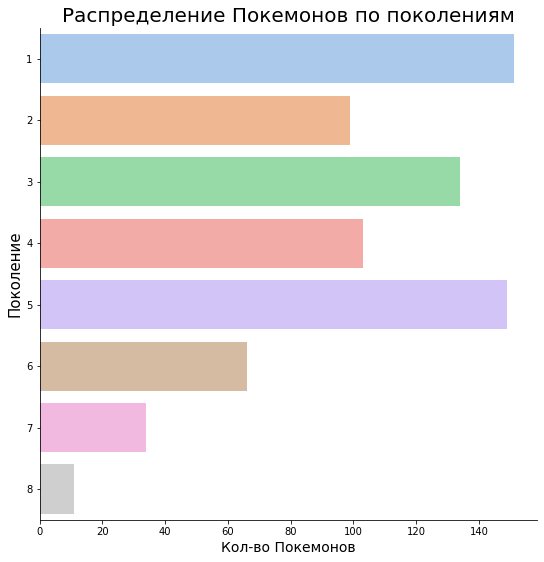

In [ ]:
# Задаем данные, тип и цвет гистограммы
g1 = sns.catplot(y='generation',
            kind='count', data=df, palette="pastel")
# Задаем названия графика, осей и его размеры
plt.xlabel("Кол-во Покемонов", fontsize = 14)
plt.ylabel("Поколение", fontsize = 15)
plt.title('Распределение Покемонов по поколениям', fontsize = 20)
g1.figure.set_figwidth(8)
g1.figure.set_figheight(8)

In [ ]:
fig1 = px.histogram(data_frame = df, x = 'generation', color = 'generation',
                    title = 'Распределение Покемонов по поколениям')
fig1.show()

На основании гистограмм можно сделать вывод, о том, что первым поколениями покемонов уделалось большее внимание в плане развития ЛОРа и франшизы как таковой. Распределение появления новых покемонов можно связать циклическими маркетинговыми ходами, когда интерес пользователя ослабевал, появлялось новое поколение персонажей (которые являлись продолжением предыдущего поколения(1-2) и (3-4) ). Когда главные герои надоедали полностью, состав обновлялся. Резкое падение числа последних поколений, можно объяснить тем, что сменилось само поколение пользователей, которые не столь заинтересованы во франшизе, однако она продолжает развитие по инерции.

### Изучим распредление общего количественного признака(характризующего "силу" покемона как такого) используя plotbox,  использующийся в описательной статистике, компактно изображающий одномерное распределение вероятностей.



In [ ]:
import matplotlib.colors as mcolors  #х загружаем различные палетки цветов
plt.figure(figsize=(10,8), dpi= 100) # задаем размеры графика
fig2 = px.box(df, x='generation', y='total',color = 'generation', title = 'Распределение количественного признака поколений покемонов')
fig2.show()

<Figure size 1000x800 with 0 Axes>

Такой вид диаграммы в удобной форме показывает медиану (или, если нужно, среднее значение, которое в поколениях практически не различается, в периодах ()1-3 и 5-8 между собой).  Расстояния между различными частями ящика позволяют определить степень разброса (дисперсии) и асимметрии данных и выявить выбросы, нижний и верхний квартили, минимальное и максимальное значение выборки. Стоит отметить, что отличительным является 4 поколение покемонов, превосходящих остальных, как в средних так и в максимальных значениях.Показатели стартовых покемонов наиболее эффективны среди других поколений и в поколении больше всего Легендарных Покемонов. Таким образом можно определить причины отличий распределения 4 поколения. Рост средних показателей последующих поколений скорее всего продиктован желанием сохранить интрес к франшизе выпуском более сильных персонажей в геймплее.

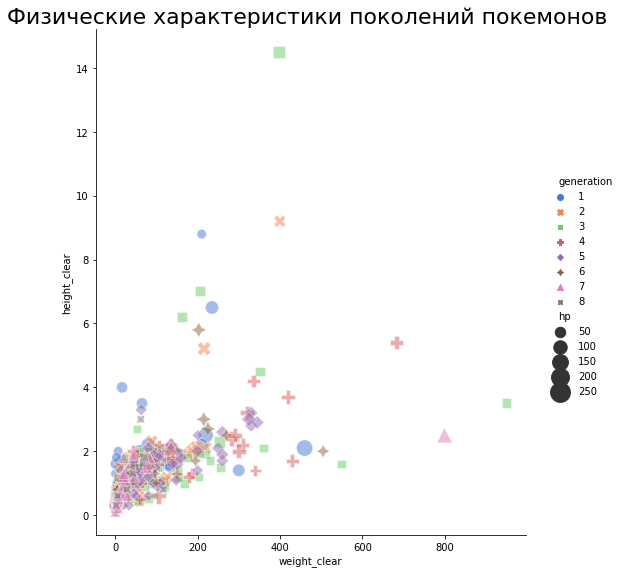

In [ ]:
# задем тип графика, данные (оси и зависимость размера и обозначений от поколения и жизенных сил), размеры, цвета из палетки)
g2 = sns.relplot(data =df, x="weight_clear", y="height_clear", hue="generation", size="hp",
            sizes=(40, 400), alpha=.5, palette="muted", style='generation',
            height=6)
plt.title('Физические характеристики поколений покемонов ', fontsize=22)
# задаем размеры графика для лучшего просмота
g2.figure.set_figwidth(8)
g2.figure.set_figheight(8)

### **Изучим Древовидную карту распределения Покемонов по первостепенным (главным) видам**

#### Ее особенность заключается в том, что она похожа на круговую диаграмму и работает лучше, не вводя в заблуждение долю каждой группы.

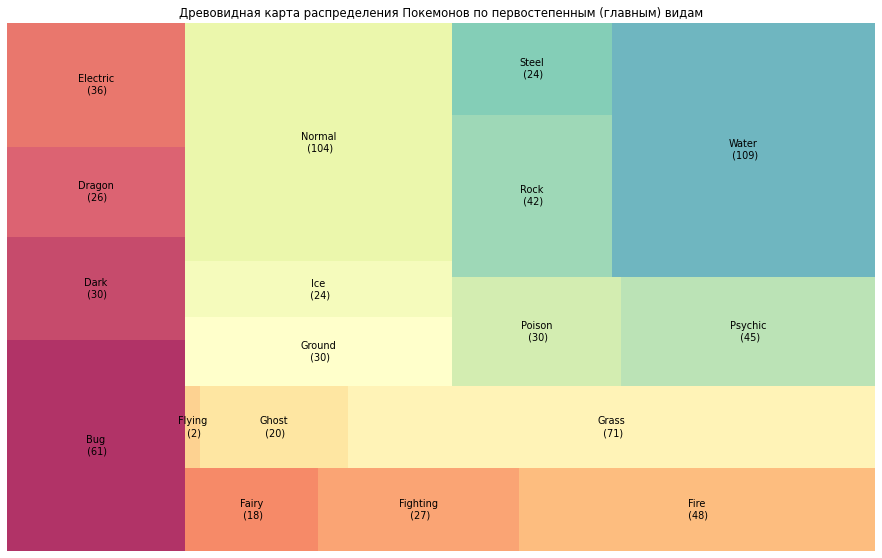

In [ ]:
df_1 = df.groupby('main_type').size().reset_index(name='counts')   # Группируем покемонов по типам
labels = df_1.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1) # Задаем подписи данных на самом графике
sizes = df_1['counts'].values.tolist() #сортируем по размерам в зависимости от численности типа
colors = [plt.cm.Spectral(i/20) for i in range(len(labels))]  # генерируем цвета цвет должен быть массивом длины полос N, поэтому перебираем длину  помощью range

# Задаем размеры
plt.figure(figsize=(16,10), dpi= 70)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8)

# Добавляем заголовок и удаляем подписи осей
plt.title('Древовидная карта распределения Покемонов по первостепенным (главным) видам')
plt.axis('off')
plt.show()

Тип — одна из важнейших характеристик покемонов и их атак, именно на взаимодействиях типов строится вся боевая система покемонов. В описании каждого типа есть указание против каких типов он суперэффективен, малоэффективен и бесполезен (похоже на "камень, ножницы, бумага"). А также какие типы суперэффективны, малоэффективны и бесполезны против него самого.

На основании древовидной карты главных типов покемонов, можно сделать выводы о наиболее частовстречающихся видах покемонов в среде обитания и следовательно дальнешего изучения преимуществ в игровом процессе.(Наиболее часто встречающиеся типы покемонов: Водяные,Нормальные, Травяные )

### **Проведем анализ Дендрограммы**

#### (Неконтролируемая классификация), которая группирует сходные точки на основе заданной метрики расстояния и упорядочивает их в виде древовидных связей на основе сходства точек.

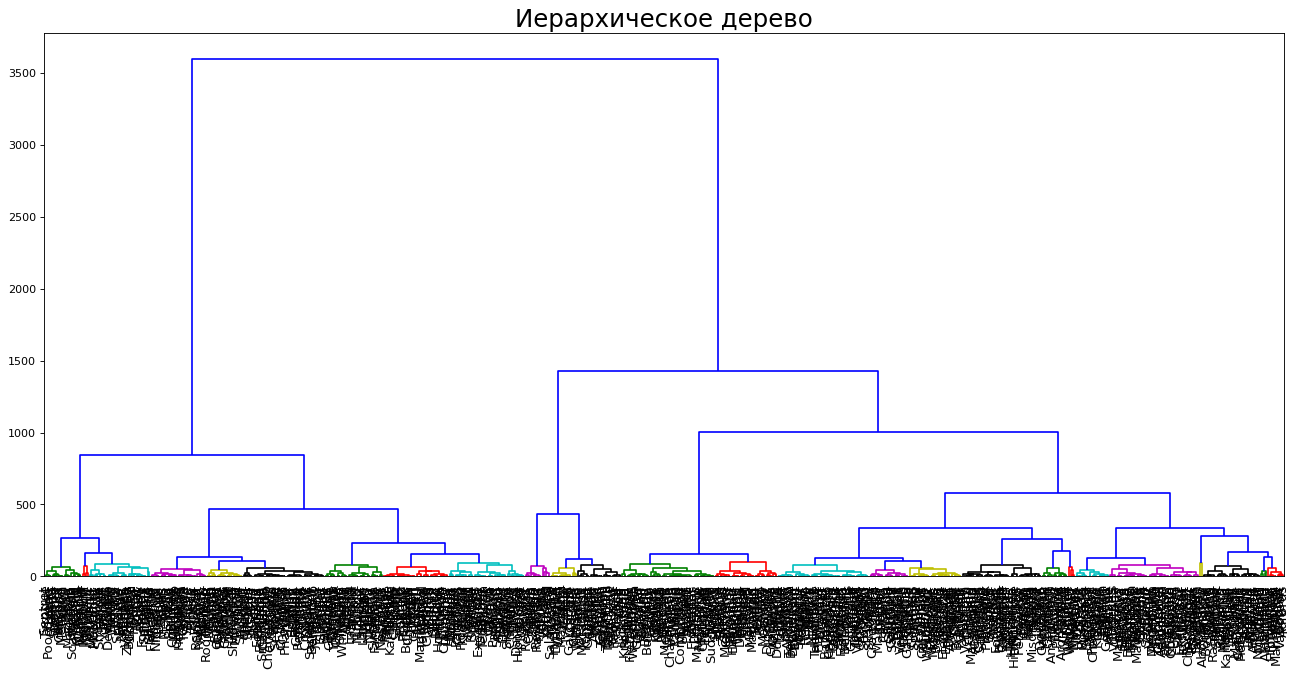

In [ ]:
import scipy.cluster.hierarchy as shc

# Задаем размеры графика, название
plt.figure(figsize=(20, 9), dpi= 80)
plt.title("Иерархическое дерево", fontsize=22)
# строим график Дендрограмму
dend = shc.dendrogram(shc.linkage(df[['total', 'hp']], method='ward'), labels=df.name.values, color_threshold=100)
plt.xticks(fontsize=12)
plt.show()

Мы продолжили группировать Покемонов. На данном мы будем использовать все числовые переменные. Это метод иерархической кластеризации, при котором различия возводятся в квадрат перед обновлением кластера. Таким образом
, метод работает с различиями или расстояниями между экземплярами. Прежде чем вычислять расстояния между экземплярами, мы сначала стандартизировали их, чтобы все они были одинаково репрезентативными. Затем мы вычислили евклидовы
расстояния между экземплярами. Соответствующая дендрограмма показана на рисунке. Мы задали 3 кластера, чтобы позволить моделировать больше
атрибутов покемонов. Стоит отметить, что приизменении выбора признаков и их количества, дендограмма остается без измнений.

### **Построим матрицу корреляции всех численных показателей покемонов**

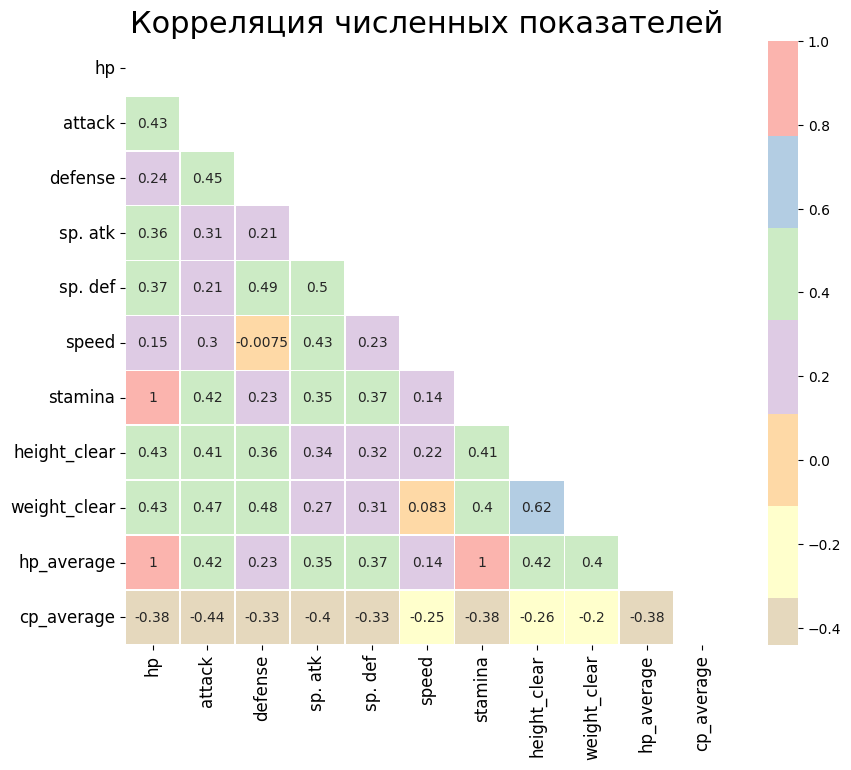

In [ ]:
numeric_col = ['hp','attack','defense','sp. atk', 'sp. def', 'speed', 'stamina', 'height_clear', 'weight_clear', 'hp_average', 'cp_average' ]
corr_matrix = df.loc[:,numeric_col].corr() # считаем корреляцию численных признаков

plt.figure(figsize=(10,8), dpi= 100)

# Рисуем тепловую карты
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, annot=True, linewidths=.5, linecolor='white', cmap="Pastel1_r", mask=mask, vmax=1, square=True, center=0)
# Подписываем график, оси, задаем размеры шрифта
plt.title('Корреляция численных показателей', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Изучив показатели корелляционной матрицы, мы можем обнаружить коррелирующие показатели. Стоит отметить, что большинство показтелей не превышают значение коэффициента 0,5. Однако, нам будет интресено наблюдать за корреляцией показателей схожих характеристик и показателей, наиболее приближенных к единице(например, роста и веса). Стоит отметить, что боевая мощь, находится в отрицательной корреляции со всеми характеристиками, следовательно можно сделать вывод о том, что чем меньше покемон по всем характеристикам, тем больше его боевая мощь. Так же интересным для нас является отрицательный коэффициент корреляции между скоростью и защитой, можно предположить, чем проворнее покемон, тем он больше уязвим. Коэфициент корреляции Выносливости и здоровья равен 1, следоватьно показатели мультиколлниарны

### **Построим Кривые плотности с гистограммой для всех интересующих нас показателей**

Кривая плотности с гистограммой объединяет сводную информацию, передаваемую двумя графиками, так что вы можете видеть оба в одном месте.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/di

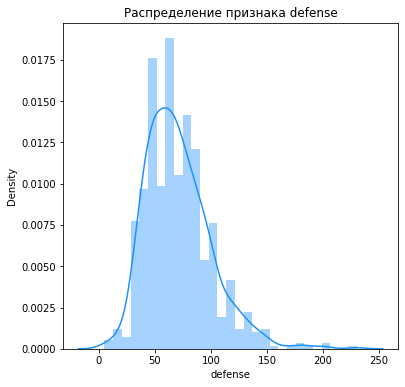

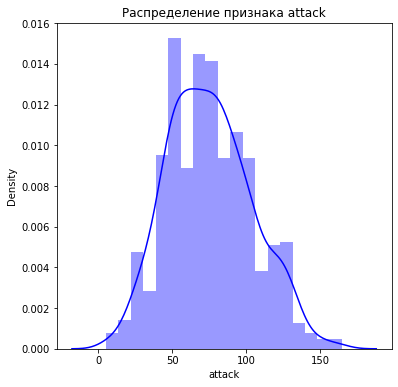

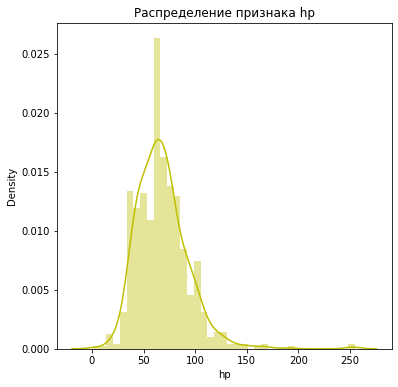

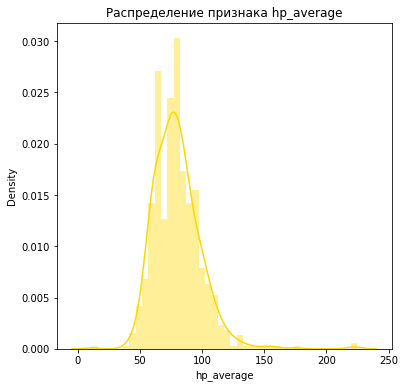

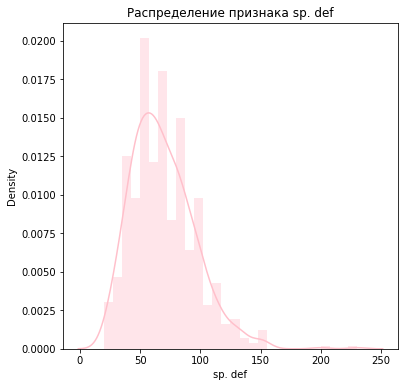

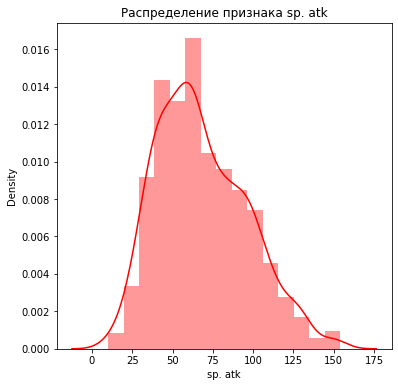

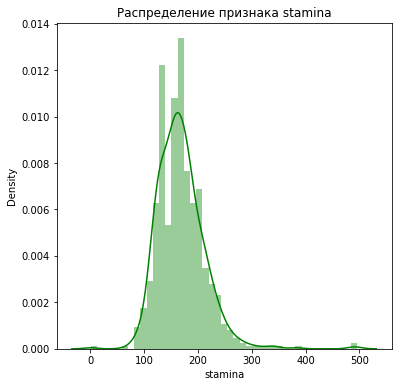

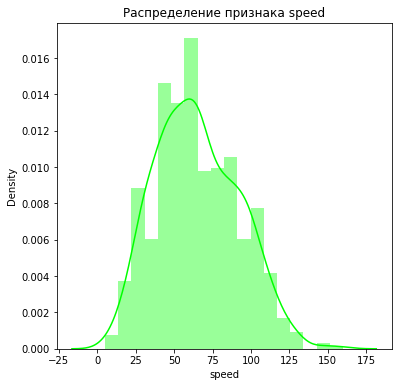

In [ ]:
label = ['defense', 'attack', 'hp', 'hp_average', 'sp. def', 'sp. atk', 'stamina', 'speed']  # список используемых характеристик
colors = ['dodgerblue', 'blue', 'y', 'gold', 'pink', 'r', 'g', 'lime'] # список используемых цветов

# задаем цикл, рисуем гистограмму и оценку плотности ядра в виде линии
for i in range(len(label)):
    plt.figure(i)
    g3 = sns.distplot(df[label[i]], color= colors[i], label= label[i])
    plt.title ('Распределение признака ' + label[i])
    g3.figure.set_figwidth(6)
    g3.figure.set_figheight(6)

Для нас в первую интересен тот факт, что практически все графики плотности распределены на одном промежутке, следовательно средние значение показателей почти идентичны, исключение составляет лишь выносливость, которая имеет другой отрезок.

### **Построим Графики линейной регрессии для веса и роста покемонов в зависимости от их пола**

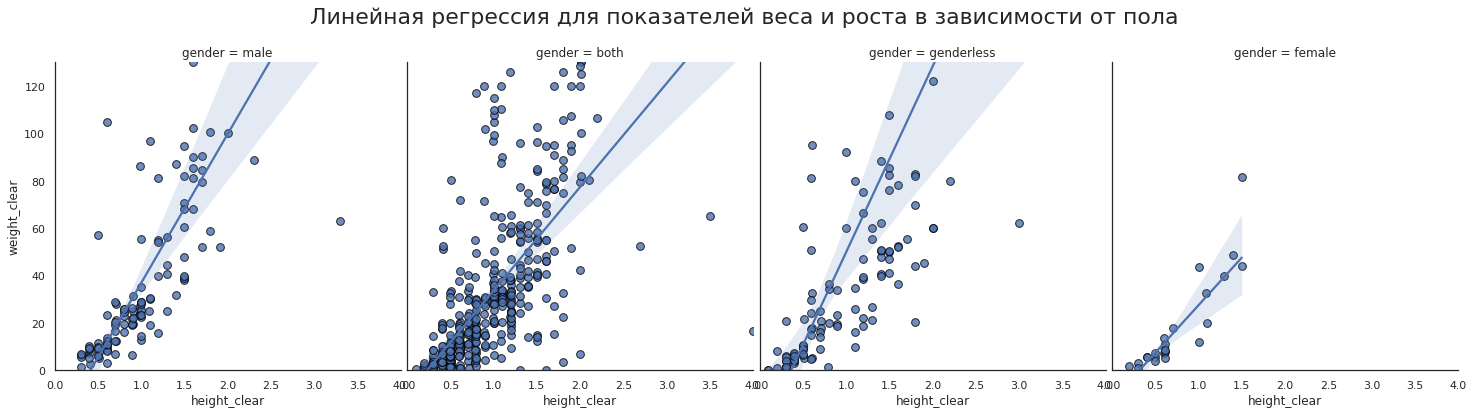

In [ ]:
sns.set_style("white")
# строим регрессионные модели для различных гендеров
gridobj = sns.lmplot(x="height_clear", y="weight_clear", col="gender", data=df,
                     height=5, aspect=2, robust=True,
                     scatter_kws=dict(s=60, linewidths=1, edgecolors='black'))

# задаем парметры осей, размеры графиков
gridobj.fig.suptitle('Линейная регрессия для показателей веса и роста в зависимости от пола', fontsize=22)
gridobj.fig.subplots_adjust(top=0.85) # сдвигаем название графика, чтобы оно не залезало на рисунок
gridobj.set(xlim=(0,4), ylim=(0, 130))
gridobj.figure.set_figwidth(20)
gridobj.figure.set_figheight(6)
plt.show()

Диаграммы рассеяния показывают явную положительную корреляцию между ростом и весом(что мы видели и в матрице корреляци): чем выше рост, тем больше вес Покемона.

Это подтверждает линия регрессии с положительным наклоном
Причём зависимость веса от роста по мужскому полу примерно равна этой же зависимости по бесполому и обееполому покемону.

Мальчик-покемон будет примерно таких же параметров что и бесполый и обееполый покемон.

Разброс весов + роста по обееполым покемонам шире, чем отдельно по М или Ж, а покемоны женского пола значительно худее остальных.
Второй и третий графики - гетероскедастичность, поскольку дисперсии случайных составляющих не равны друг другу.

## **Анализ игрового процесса**

Перейдем непосредственно к анализу данных собарнных из приложения Pokemon Go, которые характеризуют игровой процесс и выстраивают его




Построим Пауков-Цис на основе таблицы численных показателей в зависимости от региона

In [ ]:
df4 = df.groupby('region').mean() # создаем новую таблицу по регионам со средними значениями
df4 = df4[['attack', 'defense', 'sp. atk', 'sp. def', 'speed', 'stamina', 'height_clear',	'weight_clear']]
df4

,attack,defense,sp. atk,sp. def,speed,stamina,height_clear,weight_clear
region,,,,,,,,
Alola,79.968750,68.937500,71.000000,72.875000,64.906250,163.875000,0.962500,28.706250
Galar,91.363636,93.272727,60.727273,75.272727,61.000000,182.727273,1.263636,45.936364
Hoenn,72.537313,69.149254,67.246269,66.589552,60.955224,163.805970,1.227687,67.124627
Johto,67.636364,69.484848,64.040404,71.515152,61.121212,172.525253,1.139596,47.661616
Kalos,72.060606,72.984848,72.075758,72.636364,64.621212,168.863636,1.027273,50.119697
Kanto,72.913907,68.225166,67.139073,66.086093,69.066225,161.874172,1.194702,45.951656
Sinnoh,80.533981,74.728155,73.135922,73.776699,69.631068,175.834951,1.125243,72.472816
Unknown,104.000000,104.000000,67.500000,50.000000,34.000000,197.000000,1.350000,404.000000
Unova,79.899329,71.114094,67.583893,66.684564,64.932886,170.845638,1.021477,52.462416


<Figure size 432x288 with 0 Axes>

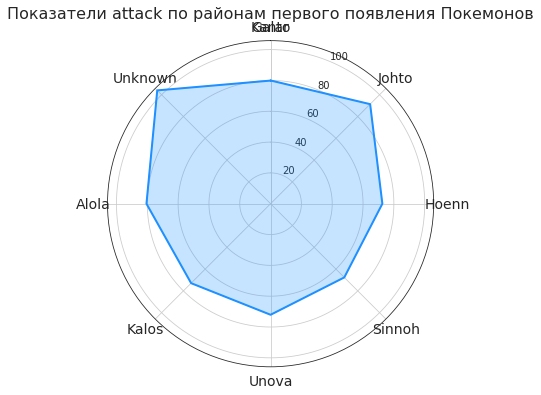

<Figure size 432x288 with 0 Axes>

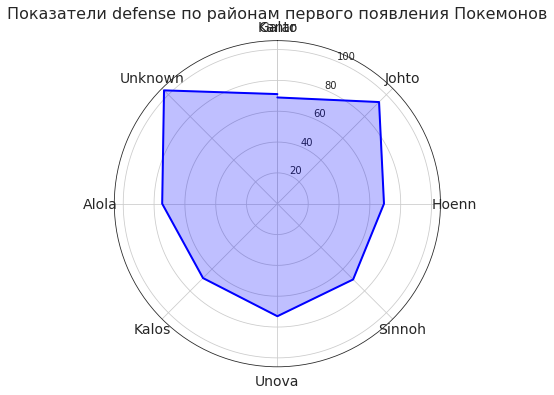

<Figure size 432x288 with 0 Axes>

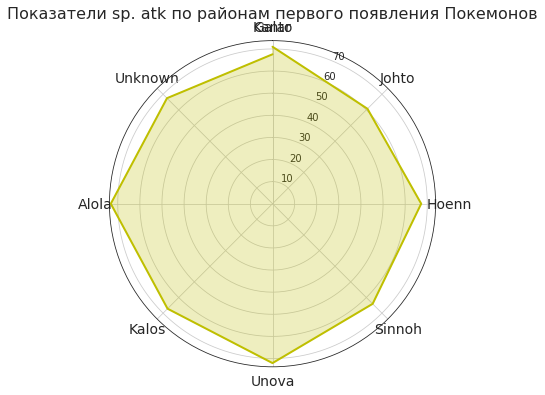

<Figure size 432x288 with 0 Axes>

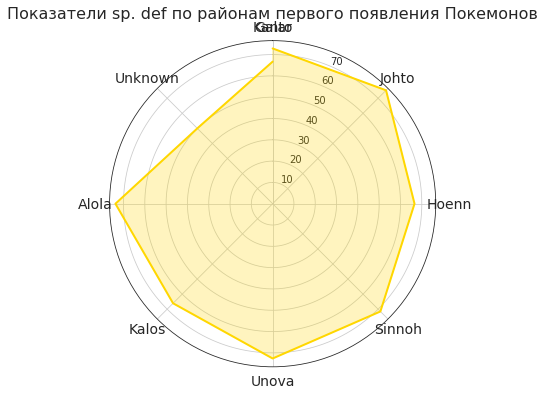

<Figure size 432x288 with 0 Axes>

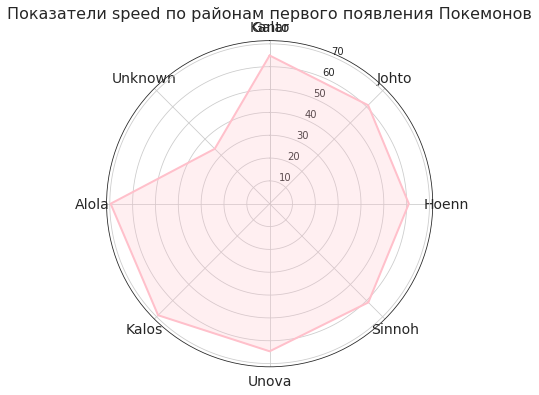

<Figure size 432x288 with 0 Axes>

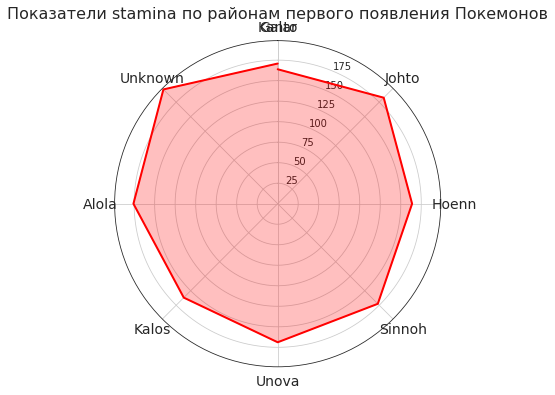

<Figure size 432x288 with 0 Axes>

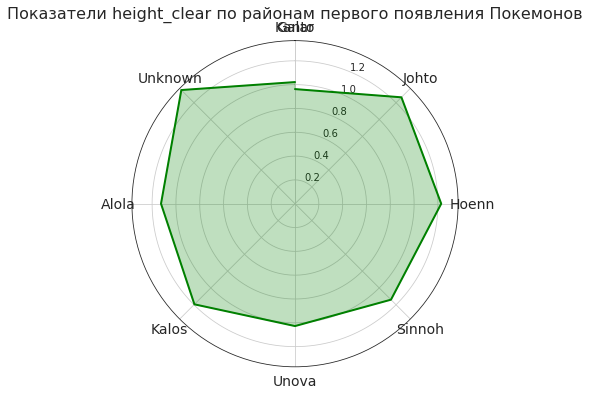

<Figure size 432x288 with 0 Axes>

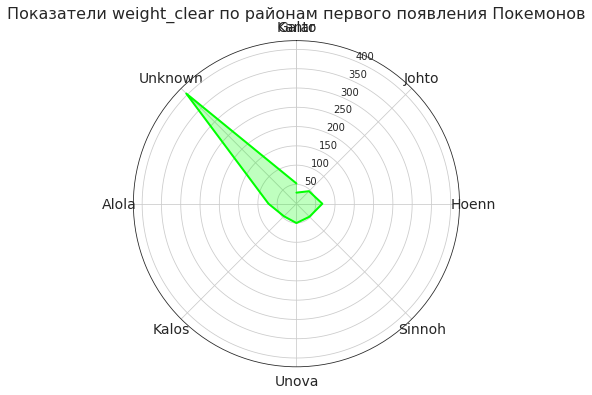

In [ ]:
# Определяем кол-во переменных и данные
labels = ['attack', 'defense', 'sp. atk', 'sp. def', 'speed', 'height_clear',	'weight_clear']
values = df4[['attack', 'defense', 'sp. atk', 'sp. def', 'speed', 'height_clear',	'weight_clear']]
regions = df['region'].unique()
v = df4.columns
colors = ['dodgerblue', 'blue', 'y', 'gold', 'pink', 'r', 'g', 'lime']
num_vars = len(regions)

# Делим круг на равные части, устанавливаем значения углов для рисования осей
angles = np.linspace(0, 2 * np.pi, num_vars-1, endpoint=False).tolist()

# Для того чтобы нарисовать полный круг, нужно добавить начальное значение в конец
regions += regions[:1]
angles += angles[:1]
c=0 #задаем переменную, чтобы менять цвета
# создаем цикл для рисования нескольких графиков для разных характеристик
for i in v:
    plt.figure(i)
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
# Рисуем линию графика
    ax.plot(angles, df4[i], color = colors[c], linewidth=2)
# Заполняем цветом внутренюю часть
    ax.fill(angles, df4[i], color = colors[c], alpha=0.25)
# Устанавлием названия графика
    ax.set_title('Показатели ' + i + ' по районам первого появления Покемонов', fontsize = 16)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

# Рисуем оси для каждого угла и подписываем
    ax.set_thetagrids(np.degrees(angles), df['region'].unique(), fontsize = 14)
    c+=1

Мы рассмотрели зависимость региона, где Покемоны впервые появились в категории игр, и средних характеристик их аттаки, защиты, скорости, выносливости, а также роста и веса.
Так показатели атаки, защиты и выносливости выше у Покемонов, появившихся впервые в Johto и неизвестных регионах. Также у появившихся впервые в Johto выше показатели специальной защиты. Показатели Специальной атаки и скорости высоки у Покемонов из каждого из регионов, но максимальное значение достигается у видов из региона Alola, Kalos и Unova. Рассматривая показатели роста и веса, можно сделать вывод, что мы не знаем, где первоначально появляются самые большие Покемоны, но высокие Покемоны чаще появляются в Hoenn и Johto.

Так большинство наиболее сильных Покемоны появились впервые в регионе Японии под названием Johto.

### **Проведем Анализ процесса поимки Покемона с помощью box plot**


In [ ]:
plt.figure(figsize=(10,8), dpi= 100)  # определяем размеры графика
fig2 = px.box(df, x='capture_rate', y='speed', color='capture_rate', title = 'Распределение скорости по вероятности поимки покемона')  # рисуем "ящики с усами" для каждого значения вероятности захвата покемона
fig2.show()

<Figure size 1000x800 with 0 Axes>

По оси X раположена вероятность поимки покемона, а по оси Y его скорость. Стоит отметить, что в данном случае возможны выбросы, скорее всего связанные с характеристикой Легендарсности покемона или предположительной "УДАЧЕЙ", обусловленной заскрпитованностью возможных квестов и сюжетов. Можно уловить взаимосвяь между скоростью и вероятностью поимки покемона, если судить по средним значениям групп. Так ,например, наибольшую скорость в среднем имеют покемоны, вероятность поймать которых составляет лишь 2%, а наименьшую, вероятность которых поймать 60%.

### **Продолжим изучение процесса поимки покемонов, используя построчные графики плотности вдоль переменных оси X и Y**

Это используется для визуализации отношений между X и Y вместе с одномерным распределением X и Y по отдельности.

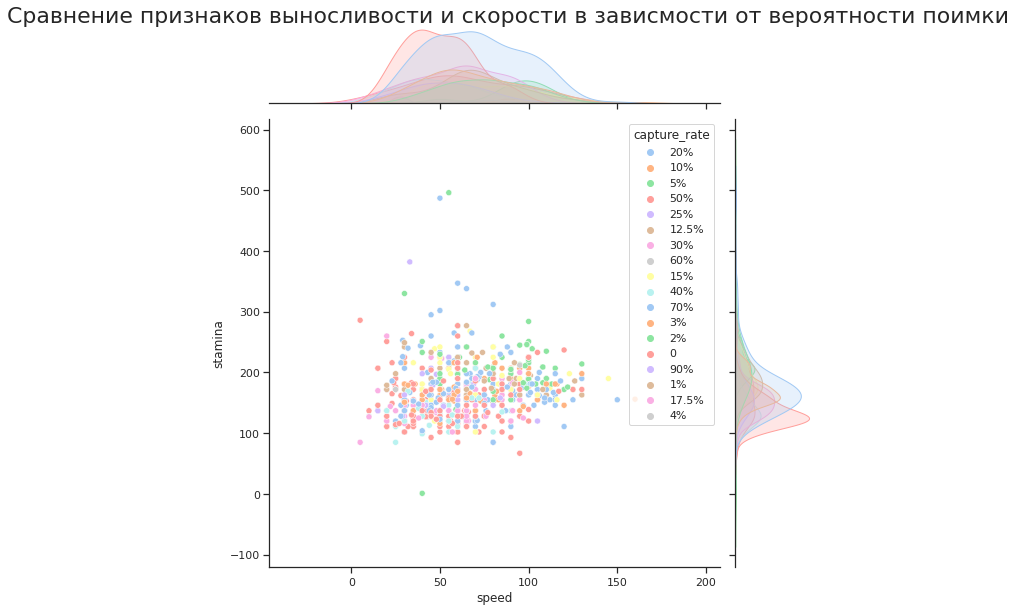

In [ ]:
sns.set_theme(style="ticks")
# Рисуем объединенный график, определяем данные, цвет и размер
g = sns.jointplot(
    data=df,
    x="speed", y="stamina", hue="capture_rate",palette="pastel")
g.fig.suptitle('Сравнение признаков выносливости и скорости в зависмости от вероятности поимки', fontsize=22)
g.fig.subplots_adjust(top=0.95) # сдвигаем название графика, чтобы оно не залезало на рисунок
g.figure.set_figwidth(9)
g.figure.set_figheight(9)

В данном случае мы добавили характристику выносливости покемонов. Исходя из построчных графиков плотности, можно сказать, что наибольшее количество покемонов можно поймать с вероятностью 50% и 20%, предположение из предыдущего пункта о зависимости скорости покмеона и вероятностью поимки подтверждается и графиком плотности распределения выносливости покемона. Покемон пойманный с вероятностью 50% будет менее выносливый, чем пойманный с вероятнотсью 20%

Хвосты слева и справа, сверху и снизу говорят о том - что не можем поймать самых медленных и самых быстрых ловких, поэтому стоит отметить, что некотрые покемоны относятся к категории "ленивых"

### **Построим Категориальные графики, которые можно использовать для визуализации распределения количества двух или более категориальных переменных по отношению друг к другу**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



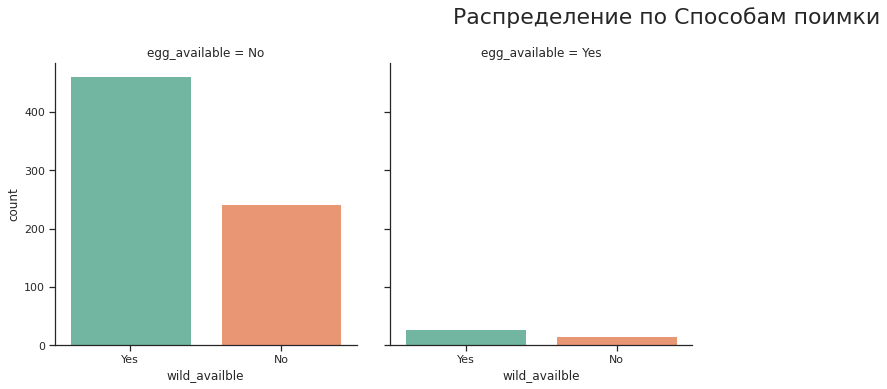

In [ ]:
# рисуем столбчатые диаграммы, разделенные по признаку egg_available
g = sns.catplot("wild_availble", col="egg_available", col_wrap=4,
                data=df,
                kind="count", height=3.5, aspect=.8,
                palette='Set2')
# устанавливаем название, размеры
g.fig.suptitle('Распределение по Способам поимки', fontsize=22)
g.fig.subplots_adjust(top=0.85) # сдвигаем название графика, чтобы оно не залезало на рисунок
g.figure.set_figwidth(20)
g.figure.set_figheight(6)
plt.show()

На основании полученныз гистограмм можно сделать выводы:
Большинство покемонов недоступных выращиванием из яйца можно поймать в дикой среде. Существует категория покемонов, которая недоступна выращиванием и ловлей их в дикой среде(предположительно третья соревновательная группа). Если покемона можно вырастить из яйца, то скорее всего это единственная возможность его добычи.

### **Построим построчные графики для покемонов, которых можно поймать в соревнованиях**

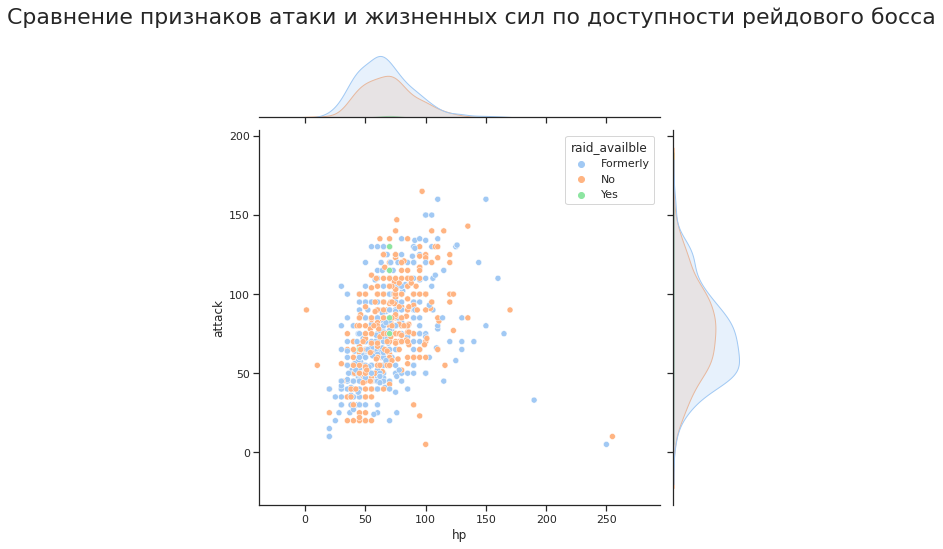

In [ ]:

# задаем тему графика, его вид и оси, за цвет отвечает признак доступности рейдового босса
g = sns.jointplot(
    data=df,
    x="hp", y="attack", hue="raid_availble",palette="pastel")
g.fig.suptitle('Сравнение признаков атаки и жизненных сил по доступности рейдового босса', fontsize=22)
g.fig.subplots_adjust(top=0.9) # сдвигаем название графика, чтобы оно не залезало на рисунок
g.figure.set_figwidth(8)
g.figure.set_figheight(8)

Поскольку анализируются соревновательные покемоны, то можно предположить зависимости характеристик атаки и здоровья от  способа поимки покемона.Исходя из построчных графиков плотности, можно сказать, что большее количество покемонов можно поймать в соревновании, но уровень здоровья будет идентичен уровню здоровья, если покемон был получен другим способом. Показатель Атаки покемона можно интерпетировать аналогичным образом.

### **Продолжим строить Категориальные графики**


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



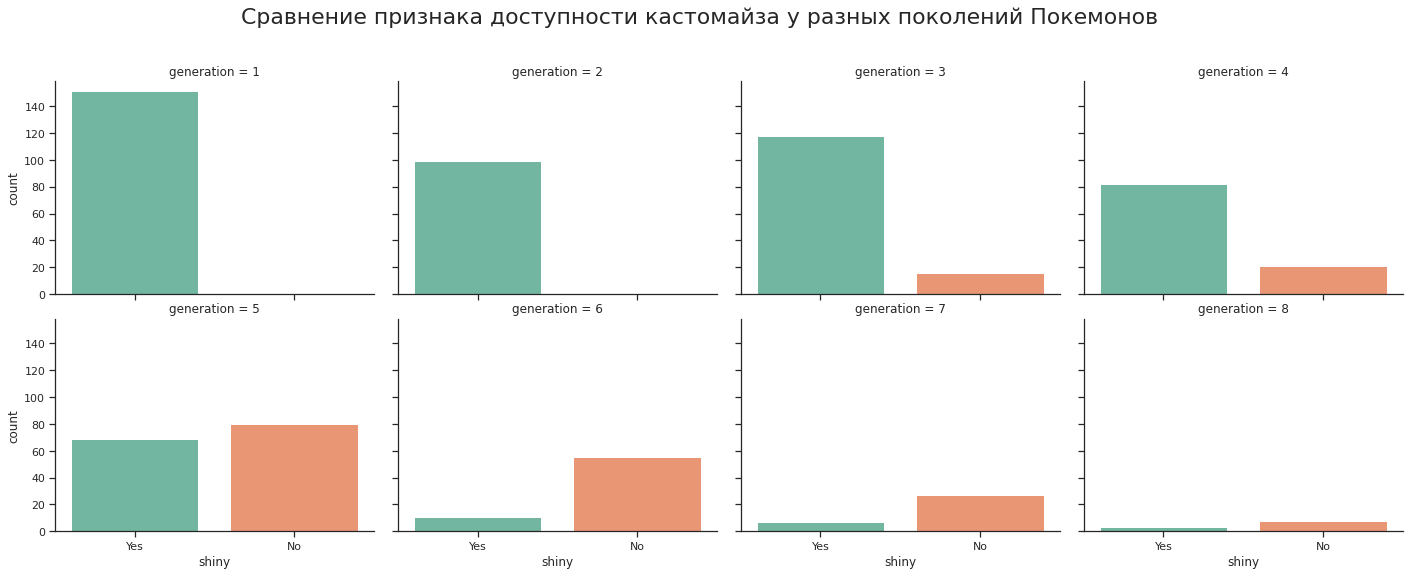

In [ ]:
g = sns.catplot("shiny", col="generation", col_wrap=4,
                data=df,
                kind="count", height=5, aspect=.8,
                palette='Set2')

g.fig.suptitle('Сравнение признака доступности кастомайза у разных поколений Покемонов', fontsize=22)
g.fig.subplots_adjust(top=0.85) # сдвигаем название графика, чтобы оно не залезало на рисунок
g.figure.set_figwidth(20)
g.figure.set_figheight(8)
plt.show()

На основании этих графиков, можно сделать вывод, о наличии возможности кастомизации покемонов разных поколений. Стоит отметить, что первые два поколения полностью экипированы аксессуарами, 3-4 поколения в большей степени, последующие поколения в меньшей степени имеют аксессуары. Это может быть вызвано более детальной проработкой образа при создании персонажей, то есть измненении концепции, или привычностью и ассоциативным рядом у пользователей со старыми поколениями, которые точно знают как они выглядят

### **Построим построчные графики плотности в зависимости от защиты и атаки для теневых покемонов**

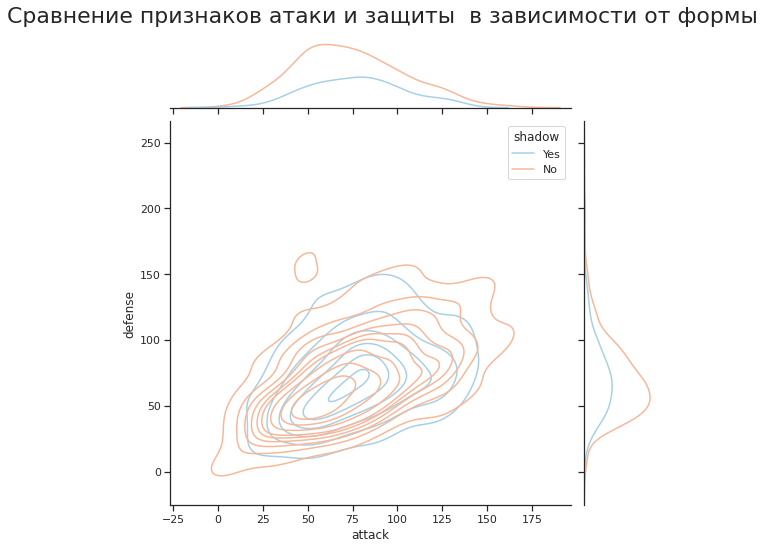

In [ ]:
# создаем "объединенный" график, задаем оси, тему
g = sns.jointplot(
    data=df,
    x="attack", y="defense", hue="shadow",
    kind="kde",palette="RdBu_r")
# задем название, размеры
g.fig.suptitle('Сравнение признаков атаки и защиты  в зависимости от формы', fontsize=22)
g.fig.subplots_adjust(top=0.92)
g.figure.set_figwidth(8)
g.figure.set_figheight(8)

Стоит отметить, что теневая форма добавочный признак, а не отдельный подвид. Теневые покемоны наносят больше урона своими быстрыми и мощными приемами, но и получают больше урона при атаке. На основании графиков, мы не может подтвержить данный тезис, взятый из описания. Независимости от признака покемона, мы можем проследить тенденцию, что с увеличением атаки защита покемона ослабевает.

#### **_Заключение_**
В этой работе был проведен статистический анализ покемонов в том виде, в каком они появляются в Pokemon Go. Мы провели одномерный анализ для всех переменных в ранее построенном наборе данных. Мы проанализировали, как распределяются числовые переменные. В
случае категориальных переменных мы использовали гистограммы с тем же концом. Тогда мы попытались найти корреляции между числовыми переменными. Чем выше характеристики покемона, тем он будет крупнее, тяжелее и его будет труднее поймать.

Основным выводом нашего анализа можно считать утверждение о том, Pokemon, как медиа-франшиза позволяет пользователю погружаться в игровой процеес  и Лор в любой момент времени, так как конечный продукт практически равнозначен по всем  исследуемым признакам.



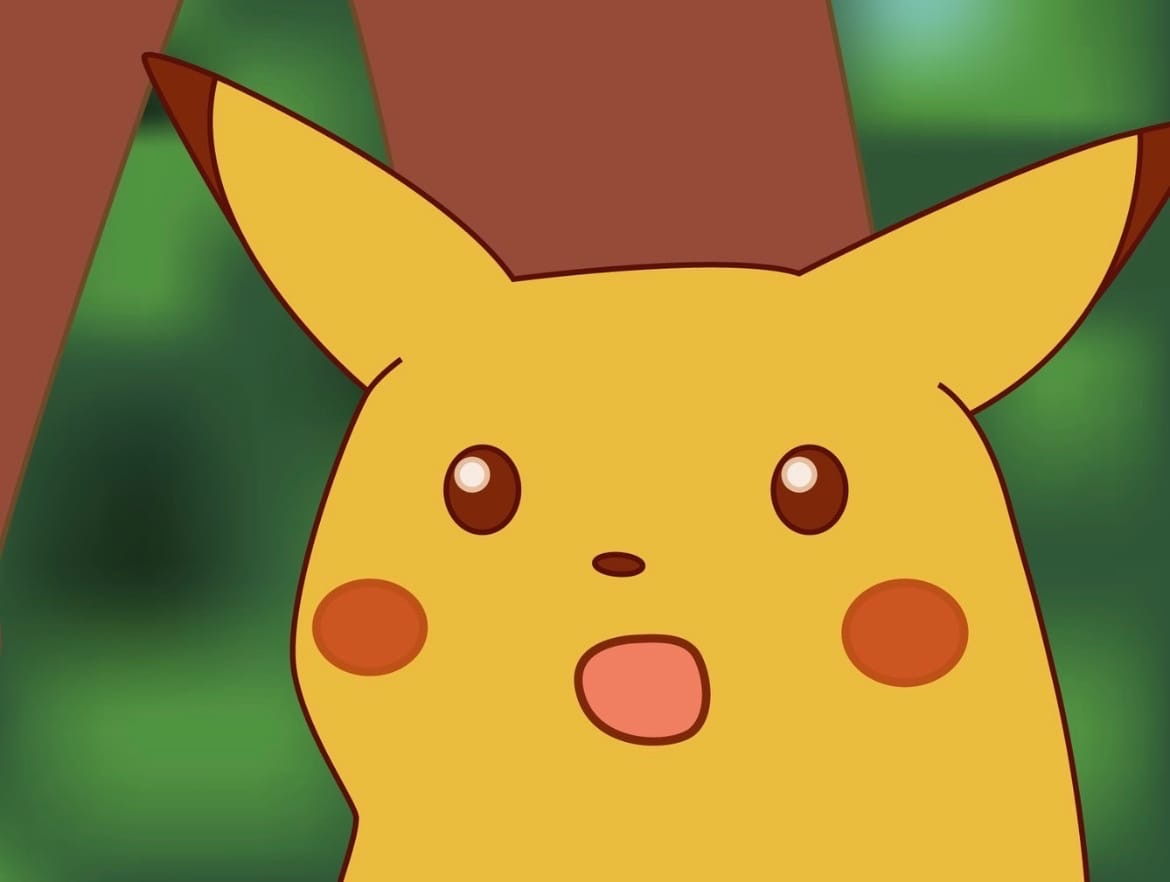